In [3]:
# default_exp preprocessing_pipeline

# Finding an optimal preprocessing pipeline for control samples

In this notebook we try to find the steps in a preprocessing pipeline that lead to a relatively homogeneous dimensionality reduction of the control samples. The idea is that we expect no process of interest in the control samples, so a good preprocessing strategy should reflect that and not introduce any unwanted artifacts. If this same strategy is applied on case (infected) samples, we can assume that effects showing up in down stream analyses are due to biological or technical artifacts and not due to the preprocessing.

See [slides](https://slides.com/mlippie/normalization-strategy)

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path
import uuid
import re
import scipy

from ehv import load as e_load, core

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [31]:
# export
from ehv import correlation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, Normalizer, VarianceThreshold
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import FastICA, PCA, KernelPCA
from umap import UMAP
from multiprocessing import Pool, cpu_count

In [207]:
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    None, "*.cif")
df = e_load.clean_column_names(df)
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)

df = df[df["meta_label_coi"]]

reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

df = df.reset_index(drop=True)

In [209]:
# drop mcp pos cells
df = df[~((df["feat_cont_area_m04"] > 0) & (df["meta_group"] == 'Ctrl'))]

## Setting up preprocessing pipelines

Steps:
1. Correlation
1. Scaling
1. Dimensionality reduction

In [37]:
# export
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import TransformerMixin, BaseEstimator, clone

In [161]:
# export
class GroupedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, base_transformer, group_key, n_jobs=-1):
        self.base_transformer = base_transformer
        self.group_key = group_key
        self.n_jobs = n_jobs if n_jobs >= 1 else cpu_count()
        
    def fit(self, df):
        self.transformers = {}
        with Pool(processes=self.n_jobs) as pool:
            for idx, gdf in df.groupby(self.group_key):
                self.transformers[idx] = pool.apply_async(clone(self.base_transformer).fit, args=(gdf.drop(columns=self.group_key),))
            for k,v in self.transformers.items():
                self.transformers[k] = v.get()
        return self
            
    def transform(self, df):
        columns = df.drop(columns=self.group_key).columns
        dfs = []
        with Pool(processes=self.n_jobs) as pool:
            promises = []
            for idx, gdf in df.groupby(self.group_key):
                promises.append(pool.apply_async(self.transformers[idx].transform, args=(gdf[columns],)))
            for (promise, (idx, gdf)) in zip(promises, df.groupby(self.group_key)):
                gdf[columns] = promise.get()
                dfs.append(gdf)
        return pandas.concat(dfs)
    
class ColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, col_selector, append=False, drop_remainder=False):
        self.transformer = transformer
        self.col_selector = col_selector
        self.append = append
        self.drop_remainder = drop_remainder
        
    def fit(self, df, y=None):
        self.transformer.fit(df[self.col_selector(df)])
        return self
    
    def transform(self, df, y=None):
        
        data = self.transformer.transform(df[self.col_selector(df)])
        if hasattr(data, "iloc"):
            tmp_df = data
        else:
            if len(self.col_selector(df)) == data.shape[1]:
                columns = self.col_selector(df)
            else:
                columns = ["feat_%s_%s" % (self.transformer.__class__.__name__.lower(), i) for i in range(data.shape[1])]
                
            tmp_df = pandas.DataFrame(
                data = data,
                columns = columns,
                index = df.index
            )
                
        if self.append:
            return pandas.concat([df, tmp_df], axis=1)
        elif self.drop_remainder:
            return pandas.concat([df.drop(columns=self.col_selector(df)), tmp_df], axis=1)
        else:
            df = df.copy()
            df[self.col_selector(df)] = tmp_df
            return df
        
    
class PandasVarianceThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=0.0):
        self.thresh = thresh
        self.var = VarianceThreshold()
        
    def fit(self, X):
        self.var.fit(X)
        return self
    
    def transform(self, X):
        return X[X.columns[self.var.get_support()]]

In [157]:
feat_selector = make_column_selector(pattern="feat")
meta_selector = make_column_selector(pattern="^(feat|meta_timepoint).*")

## Robust scale

In [12]:
pipe = Pipeline([
    ("correlation", ColumnTransformer(correlation.Correlation(0.92), meta_selector)),
    ("grouped_robust_scaler", ColumnTransformer(GroupedTransformer(RobustScaler(quantile_range=(0.05, 0.95)), "meta_timepoint"), meta_selector)),
    ("pca", ColumnTransformer(PCA(n_components=0.95, random_state=42), feat_selector, append=True)),
    ("umap", ColumnTransformer(UMAP(n_components=2, random_state=42), make_column_selector(pattern="feat_pca"), append=True))
])

In [14]:
%%time
res = pipe.fit_transform(df[df["meta_group"] == "Ctrl"])

CPU times: user 49min 19s, sys: 15min 22s, total: 1h 4min 42s
Wall time: 7min 46s


<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

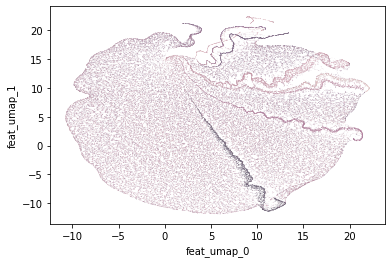

In [15]:
seaborn.scatterplot(data=res, x="feat_umap_0", y="feat_umap_1", hue="meta_timepoint", s=0.1, alpha=0.5, edgecolors='none', legend=False)

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

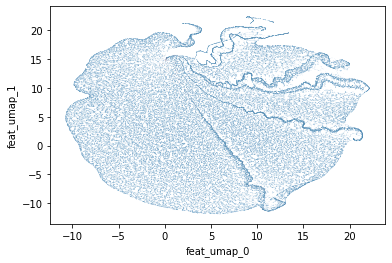

In [16]:
seaborn.scatterplot(data=res, x="feat_umap_0", y="feat_umap_1", hue="meta_label", hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg", "unknown"], legend=False, s=0.1, alpha=0.5, edgecolors='none')

# Minmax + standard scale

In [88]:
%%time
pipe = Pipeline([
    ("correlation", ColumnTransformer(correlation.Correlation(0.92), meta_selector)),
    ("grouped_minmax_scaler", ColumnTransformer(GroupedTransformer(MinMaxScaler(), "meta_timepoint"), meta_selector)),
    ("grouped_standard_scaler", ColumnTransformer(GroupedTransformer(StandardScaler(), "meta_timepoint"), meta_selector)),
    ("pca", ColumnTransformer(PCA(n_components=0.95, random_state=42), feat_selector, append=True)),
    ("umap", ColumnTransformer(UMAP(n_components=2, random_state=42), make_column_selector(pattern="feat_pca"), append=True))
])
res2 = pipe.fit_transform(df[df["meta_group"] == "Ctrl"])

/opt/conda/envs/env/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


KeyboardInterrupt: 

In [89]:
seaborn.scatterplot(data=res2, x="feat_umap_0", y="feat_umap_1", hue="meta_timepoint", s=0.1, alpha=0.5, edgecolors='none', legend=False)

NameError: name 'res2' is not defined

# Normalize + Power transform

In [ ]:
# export
def make_pipeline_1():
    return Pipeline([
        ("zero_var", ColumnTransformer(PandasVarianceThreshold(), feat_selector, drop_remainder=True)),
        ("correlation", ColumnTransformer(correlation.Correlation(0.92), feat_selector, drop_remainder=True)),
        ("normalize", ColumnTransformer(Normalizer(), feat_selector)),
        ("power_transform", ColumnTransformer(PowerTransformer(), feat_selector)),
        ("pca", ColumnTransformer(PCA(n_components=0.95, random_state=42), feat_selector, append=True)),
        ("umap", ColumnTransformer(UMAP(n_components=2, random_state=42, metric="cosine"), make_column_selector(pattern="feat_pca"), append=True))
    ])

In [211]:
%%time
pipe = make_pipeline_1()

# Feedback needed from Flora about ch2 and ch3
res3 = pipe.fit_transform(df[df["meta_group"] == "Ctrl"].drop(columns=df.filter(regex="(m|ch)0?(2|3)")))

CPU times: user 10min 31s, sys: 2min 31s, total: 13min 3s
Wall time: 3min 25s


In [227]:
u = uuid.uuid4()

In [228]:
dump(res3.filter(regex="feat_umap"), "/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Ctrl/%s.dat" % u)

['/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Ctrl/3654c1c0-dac4-47af-a32a-bd84ccef036e.dat']

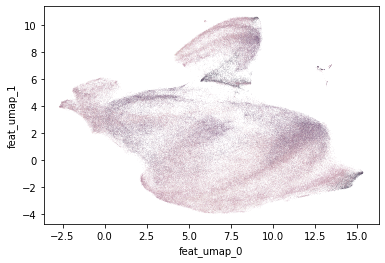

In [229]:
seaborn.scatterplot(data=res3, x="feat_umap_0", y="feat_umap_1", hue="meta_timepoint", s=0.1, alpha=0.5, edgecolors='none', legend=False)
plt.savefig("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/assets/thumbs/%s.jpg" % u)

In [213]:
res3.filter(regex="feat").corr()["feat_umap_1"].abs().sort_values(ascending=False)

feat_umap_1                                     1.000000
feat_pca_1                                      0.683473
feat_cont_bright_detail_intensity_r3_mc_ch11    0.582028
feat_cont_bright_detail_intensity_r3_mc_bf2     0.565190
feat_cont_median_pixel_m09_bf2                  0.559598
                                                  ...   
feat_cont_intensity_mc_ch04                     0.029200
feat_cont_contrast_m06_ssc                      0.026857
feat_pca_3                                      0.021152
feat_pca_15                                     0.012005
feat_cont_modulation_m11_ch11                   0.004361
Name: feat_umap_1, Length: 76, dtype: float64

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

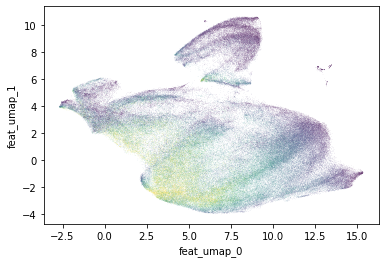

In [214]:
feat = "feat_cont_bright_detail_intensity_r3_mc_ch11"
norm = matplotlib.colors.Normalize(vmin=df[df["meta_group"] == 'Ctrl'][feat].quantile(0.05), vmax=df[df["meta_group"] == 'Ctrl'][feat].quantile(0.95))
seaborn.scatterplot(data=res3, x="feat_umap_0", y="feat_umap_1", c=df[df["meta_group"] == 'Ctrl'][feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)

In [215]:
res3.filter(regex="feat").corr()["feat_umap_0"].abs().sort_values(ascending=False)[:20]

feat_umap_0                                1.000000
feat_cont_gradient_rms_m09_bf2             0.875833
feat_cont_gradient_rms_m07_ch7             0.874912
feat_cont_gradient_rms_m11_ch11            0.864840
feat_cont_gradient_rms_m06_ssc             0.864359
feat_pca_0                                 0.851223
feat_cont_width_m07                        0.847530
feat_cont_modulation_m07_ch7               0.835762
feat_cont_gradient_rms_m01_bf              0.832634
feat_cont_width_m01                        0.813456
feat_cont_width_m11                        0.772593
feat_cont_aspect_ratio_m01                 0.766820
feat_cont_max_pixel_mc_bf                  0.766571
feat_cont_aspect_ratio_intensity_m01_bf    0.766225
feat_cont_width_m09                        0.758398
feat_cont_aspect_ratio_m11                 0.757501
feat_cont_aspect_ratio_m07                 0.756995
feat_cont_contrast_m07_ch7                 0.752857
feat_cont_aspect_ratio_m09                 0.750183
feat_cont_he

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

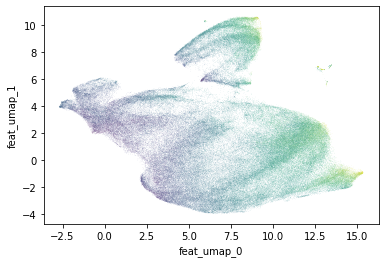

In [216]:
feat = "feat_cont_gradient_rms_m09_bf2"
norm = matplotlib.colors.Normalize(vmin=res3[feat].quantile(0), vmax=res3[feat].quantile(1))
seaborn.scatterplot(data=res3, x="feat_umap_0", y="feat_umap_1", c=res3[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

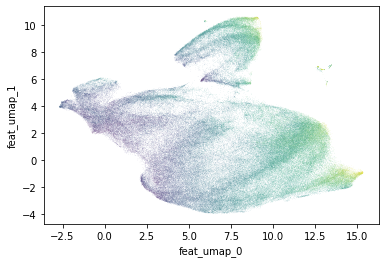

In [217]:
feat = "feat_cont_gradient_rms_m07_ch7"
norm = matplotlib.colors.Normalize(vmin=res3[feat].quantile(0), vmax=res3[feat].quantile(1))
seaborn.scatterplot(data=res3, x="feat_umap_0", y="feat_umap_1", c=res3[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

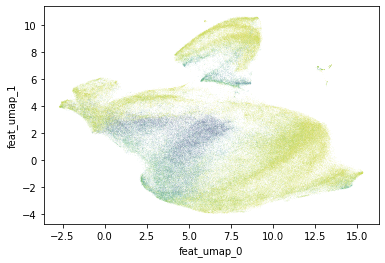

In [218]:
feat = "feat_cont_aspect_ratio_intensity_m07_ch7"
norm = matplotlib.colors.Normalize(vmin=df[df["meta_group"] == 'Ctrl'][feat].quantile(0), vmax=df[df["meta_group"] == 'Ctrl'][feat].quantile(1))
seaborn.scatterplot(data=res3, x="feat_umap_0", y="feat_umap_1", c=df[df["meta_group"] == 'Ctrl'][feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)

In [219]:
%%time
# Feedback needed from Flora about ch2 and ch3
res4 = pipe.fit_transform(df[df["meta_group"] == "Low"].drop(columns=df.filter(regex="(m|ch)0?(2|3)")))

CPU times: user 21min 59s, sys: 4min 50s, total: 26min 50s
Wall time: 5min 48s


In [230]:
u = uuid.uuid4()

In [231]:
dump(res4.filter(regex="feat_umap"), "/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Ctrl/%s.dat" % u)

['/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Ctrl/b4fb7334-7ca5-408a-a136-256358f81190.dat']

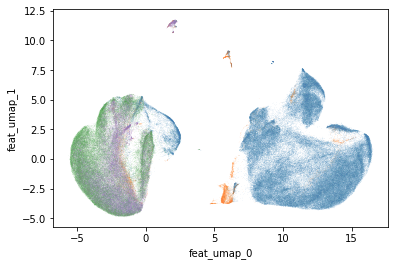

In [232]:
seaborn.scatterplot(data=res4, x="feat_umap_0", y="feat_umap_1", hue="meta_label", s=0.1, alpha=0.5, edgecolors='none', legend=False)
plt.savefig("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/assets/thumbs/%s.jpg" % u)

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

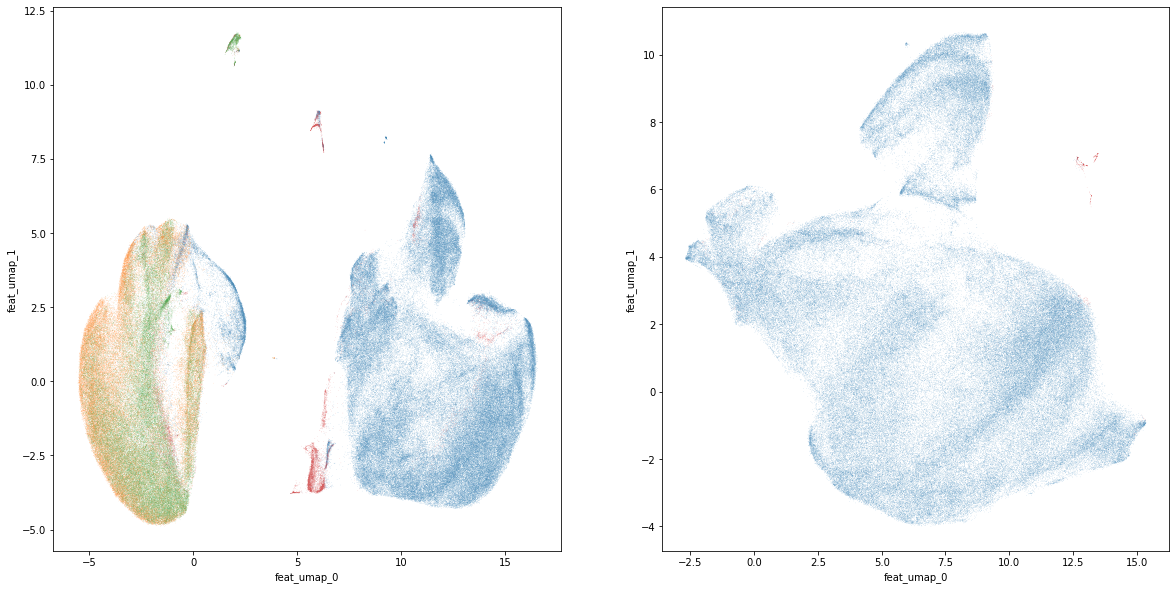

In [220]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
seaborn.scatterplot(
    data=res4, x="feat_umap_0", y="feat_umap_1", 
    hue="meta_label", hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg", "unknown"],
    s=0.2, alpha=0.5, edgecolors='none', legend=False, ax=ax[0])
seaborn.scatterplot(
    data=res3, x="feat_umap_0", y="feat_umap_1", 
    hue="meta_label", hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg", "unknown"],
    s=0.2, alpha=0.5, edgecolors='none', legend=False, ax=ax[1])

In [223]:
res4.filter(regex="feat").corr()["feat_umap_1"].sort_values(ascending=False)[:20]

feat_umap_1                                    1.000000
feat_cont_area_mc                              0.714225
feat_cont_bright_detail_intensity_r3_mc_bf2    0.707011
feat_cont_height_m09                           0.674563
feat_cont_length_m09                           0.667835
feat_cont_modulation_m09_bf2                   0.667522
feat_cont_width_m09                            0.664753
feat_cont_height_m01                           0.647928
feat_cont_bright_detail_intensity_r3_mc_bf     0.647236
feat_cont_width_m06                            0.642410
feat_cont_length_m01                           0.642390
feat_cont_area_m01                             0.634993
feat_cont_width_m01                            0.621444
feat_cont_gradient_rms_m01_bf                  0.617208
feat_cont_height_m06                           0.605364
feat_cont_area_m06                             0.604648
feat_cont_width_m07                            0.601394
feat_cont_contrast_m09_bf2                     0

In [224]:
res4.filter(regex="feat").corr()["feat_umap_1"].sort_values(ascending=False)[-20:]

feat_cont_max_pixel_mc_ch11                     0.026817
feat_pca_16                                     0.019626
feat_pca_12                                     0.002536
feat_pca_17                                    -0.012149
feat_pca_13                                    -0.015289
feat_pca_10                                    -0.025390
feat_pca_15                                    -0.032710
feat_pca_9                                     -0.039829
feat_cont_bright_detail_intensity_r3_mc_ch11   -0.074318
feat_cont_bright_detail_intensity_r3_mc_ch7    -0.091824
feat_pca_5                                     -0.096234
feat_pca_6                                     -0.119788
feat_cont_contrast_m11_ch11                    -0.128650
feat_pca_4                                     -0.152405
feat_cont_intensity_mc_bf2                     -0.187027
feat_cont_mean_pixel_m09_bf2                   -0.241730
feat_cont_mean_pixel_m01_bf                    -0.321331
feat_cont_intensity_mc_bf      

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

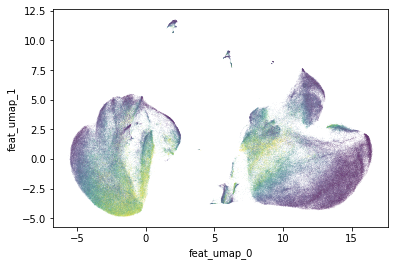

In [222]:
feat = "feat_cont_area_mc"
norm = matplotlib.colors.Normalize(vmin=df[df["meta_group"] == 'Low'][feat].quantile(0.05), vmax=df[df["meta_group"] == 'Low'][feat].quantile(0.95))
seaborn.scatterplot(data=res4, x="feat_umap_0", y="feat_umap_1", c=df[df["meta_group"] == 'Low'][feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

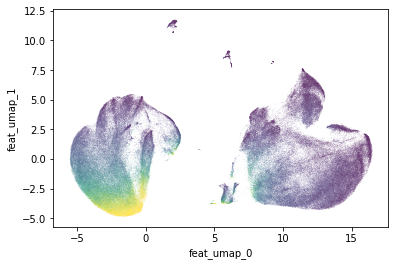

In [225]:
feat = "feat_cont_intensity_mc_ch7"
norm = matplotlib.colors.Normalize(vmin=df[df["meta_group"] == 'Low'][feat].quantile(0.05), vmax=df[df["meta_group"] == 'Low'][feat].quantile(0.95))
seaborn.scatterplot(data=res4, x="feat_umap_0", y="feat_umap_1", c=df[df["meta_group"] == 'Low'][feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

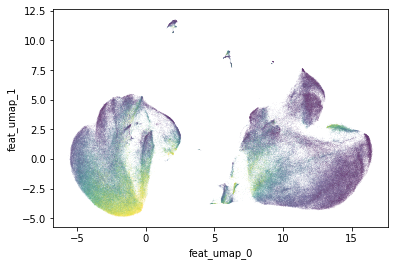

In [226]:
feat = "feat_cont_area_m07"
norm = matplotlib.colors.Normalize(vmin=df[df["meta_group"] == 'Low'][feat].quantile(0.05), vmax=df[df["meta_group"] == 'Low'][feat].quantile(0.95))
seaborn.scatterplot(data=res4, x="feat_umap_0", y="feat_umap_1", c=df[df["meta_group"] == 'Low'][feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)

In [54]:
def do_median_centering(df):
    df[df.filter(regex="feat").columns] -= df.median()
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_median_centering)

In [81]:
def do_mean_centering(df):
    df[df.filter(regex="feat").columns] -= df.mean()
    return df

df = df.groupby(["meta_timepoint"]).apply(do_mean_centering)